# COVID19 severe (hospitalized) cases in Brazil

# Univariate logistic regression - results

Publicly available data for hospitalized cases in Brazil is used to perform a retrospective cross-sectional observational study.

It means that we want to infer the paramaters driving the outcome from data gathered from hospitals.
The data has been downloaded, selected and preprocessed before the steps described in this notebook.

The aim is to compare different variants and infer what parameters are driving the severity and the outcome.<br>
I proceed as follow:
<ol>
    <li> Compute some new features from the data (time between some dates, etc) and explore data</li>
    <li> Perform univariate logistic regression</li>
            <ol><li>Perform regression</li><li><strong>Show results (Presented in this notebook)</strong></li></ol>
    <li> Based on the result of the univariate regression, move to a multivariate logistic regression with stepwise approach.</li>
</ol>
    
| Features in the data | Features added | Primary Outcome (Label) | Secondary Outcome |
|-|-|-|-|
| age | age group | death/cured | ICU admission |
| sex | nber of comorbidities | | ventilation (invasive/noninvasive) |
| ethnicity | nber of vaccine doses received | | |
| Federative unit (i.e., state) | delay between last dose of vaccine (if >=2) and 1st symptoms | | |
| symptoms | length of hospital stay | | |
| comorbidities | delay between 1st symptoms and hospitalization | | |
| pregnancy status | | | |

This is applied to four different periods of time when four different variants where dominant (>=80% of samples analyzed were corresponding to the variant of interest, source: GISAID database):
- Delta
- Omicron BA.1
- Omicron BA.2
- Omicron BA.4/BA.5

> **Data source**: all the data has been taken from the Brazilian Ministry of Health https://opendatasus.saude.gov.br/organization/ministerio-da-saude
>
>It requires translation from Portuguese to English

- Define reference for each categorical parameter

| Features | Reference |
|-|-|
| State | Distrito Federal (DF) |
| Age group | Age group 3 (25-44 y) |
| ethnicity | White |
| Number of comorbidities | 0 |
| Ventilation | No ventilation |
| Ventilation out of ICU | No ventilation |
| Invasive ventilation | In ICU |
| ICU admission | No |
| Delay between last vaccine dose and first symptom | <90 days |
| Comorbidities | No comorbidity |

## Python module used in this notebook

In [1]:
import pandas as pd
import scipy.stats as scst
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm

## Parameters definition: 

- variant period of time/names
- age class
- comorbidity list in English
- ethnicity list in English
- list to replace wording for labels

In [2]:
variants_period = [['2021-09-12','2021-12-19'],['2022-01-03','2022-03-20'],['2022-04-11','2022-05-29'],
                   ['2022-07-18','2022-10-02']]
variants_name = ['Delta','BA.1.X','BA.2.X','BA.4/5.X']
file_name = ['Delta','BA1X','BA2X','BA45X']
#age_class = [[0,4],[5,9],[10,14],[15,19],[20,29],[30,39],[40,49],[50,59],[60,64],[65,69],[70,74],[75,79],[80]]
age_range = [[0,4],[5,14],[15,24],[25,44],[45,54],[55,64],[65]]
age_code = [0,1,2,3,4,5,6]
gender = ['Female','Male']
comorb_list = ['cardiovascular_disease','hematologic_disease','down_syndrom','liver_disease','asthma','diabetes',
          'neurological_disease','chronic_lung_disease','weaken_immune_system','renal_disease','obesity','puerperal',
               'other_comorbidities']
race_list = ['Indigenous','Brown','Asian','Black','White','Unknown']
univariate_parameters_withref = ['state','age_group','sex','ethnicity','nb_comorbidities','nb_vaccine_dose','icuadm',
                                 'ventilation ','ventilation_outoficu','invasive_ventilation','delay_vaccine']
references = ['state DF','age_group 3','sex Female','ethnicity white','nb_comorbidities 0','nb_vaccine_dose 0','icuadm No',
             'No ventilation','No ventilation_outoficu','invasive_ventilation In ICU','delay_vaccine <90']
univariate_parameters = ['length_stay','length_delay']
df_encoded = pd.read_parquet('encoded_severe_cases_data.pq')
replace_label = [['age_group 0','0-4 y'],['age_group 1','5-14 y'],['age_group 2','15-24 y'],['age_group 3','25-44 y'],
                 ['age_group 4','45-54 y'],['age_group 5','55-64 y'],['age_group 6','65+ y'],['icuadm','ICU adm'],
                 ['ventilation_outoficu','Ventilation out of ICU'],
                 ['delay_vaccine','delay between last vaccine dose (2+) and 1st symp'],
                 ['90','90d'],['_',' ']]

## Univariate logistic regression results

- Load data for categorical data per variant

In [3]:
data = pd.read_csv('categorical_by_variant_reg.csv')

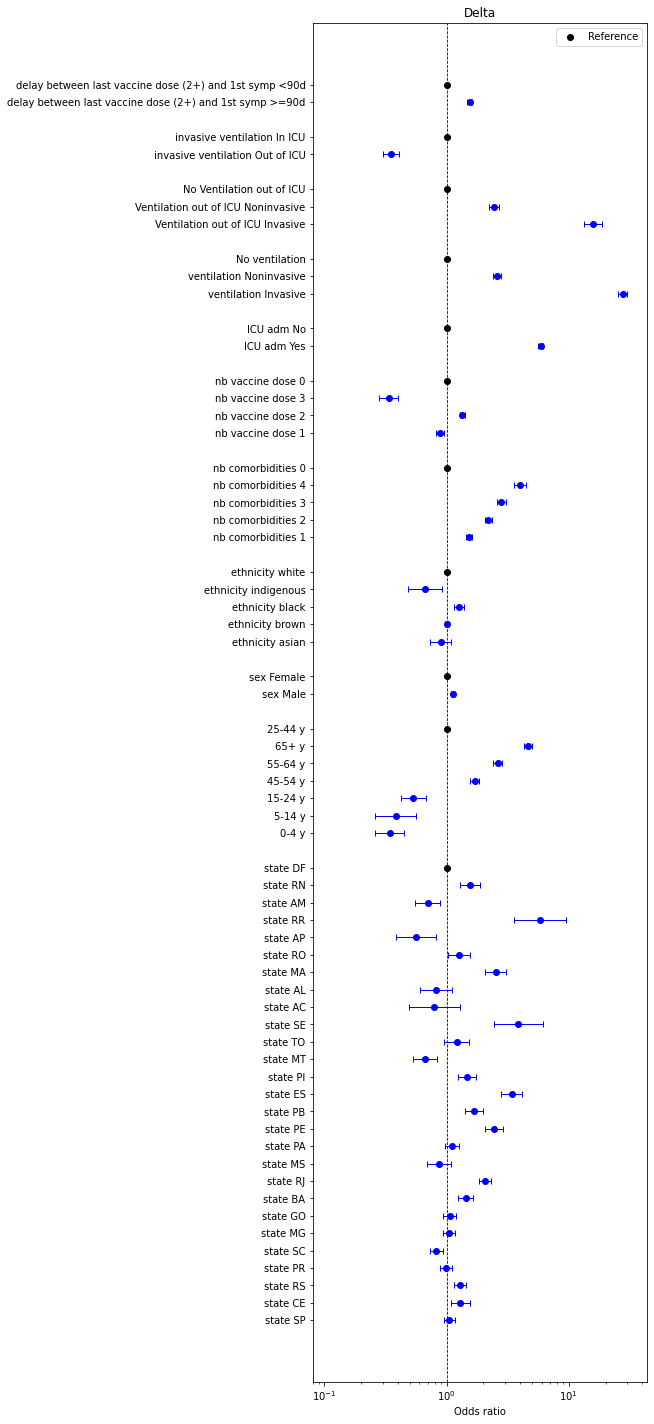

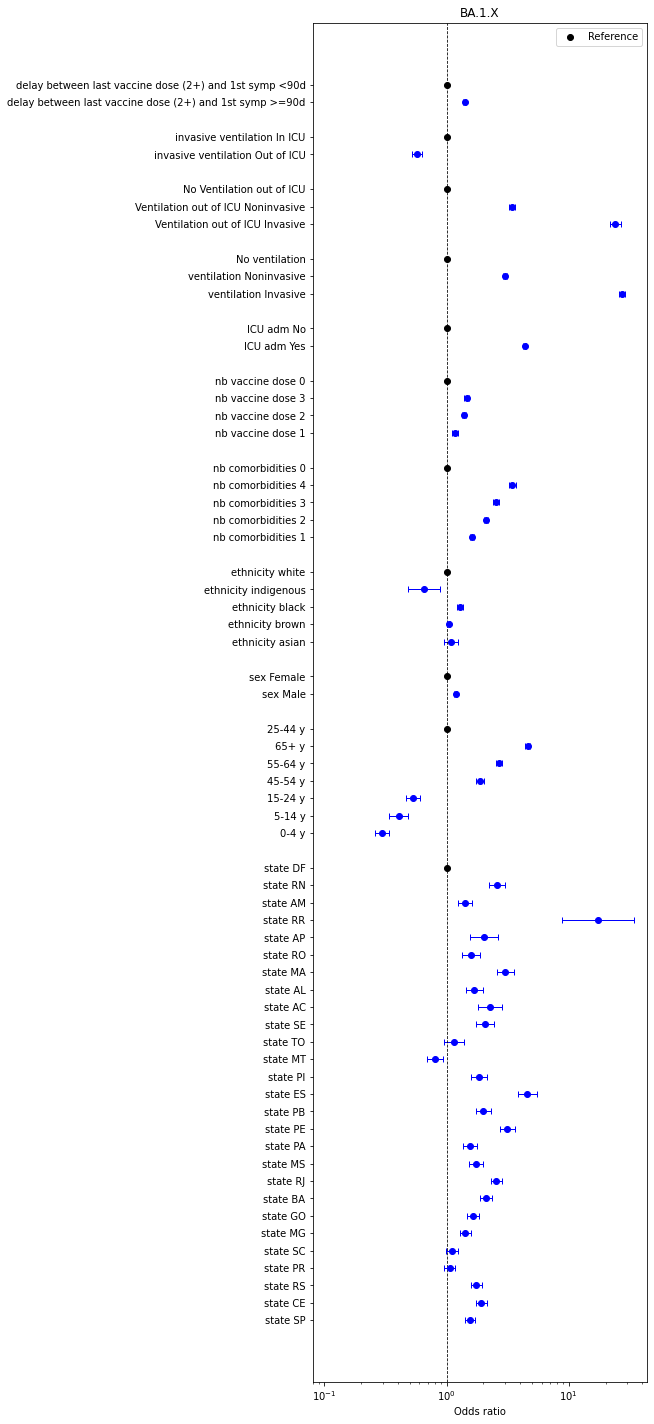

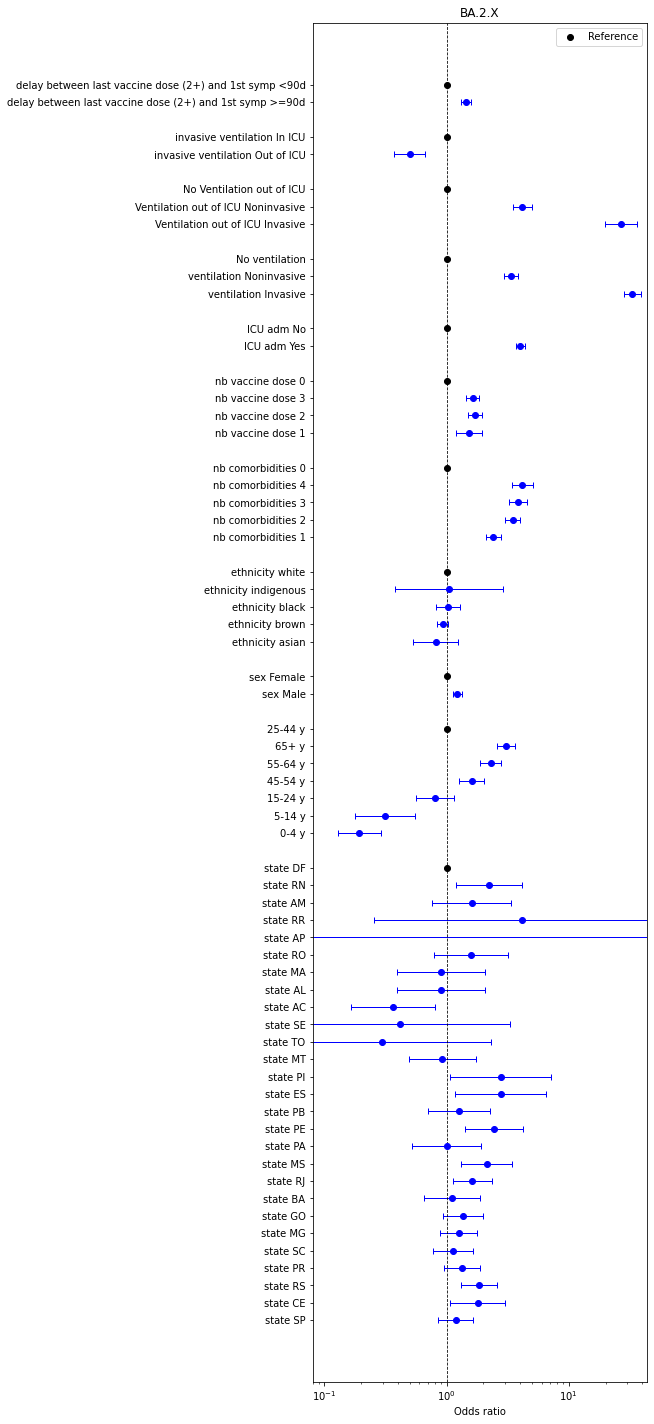

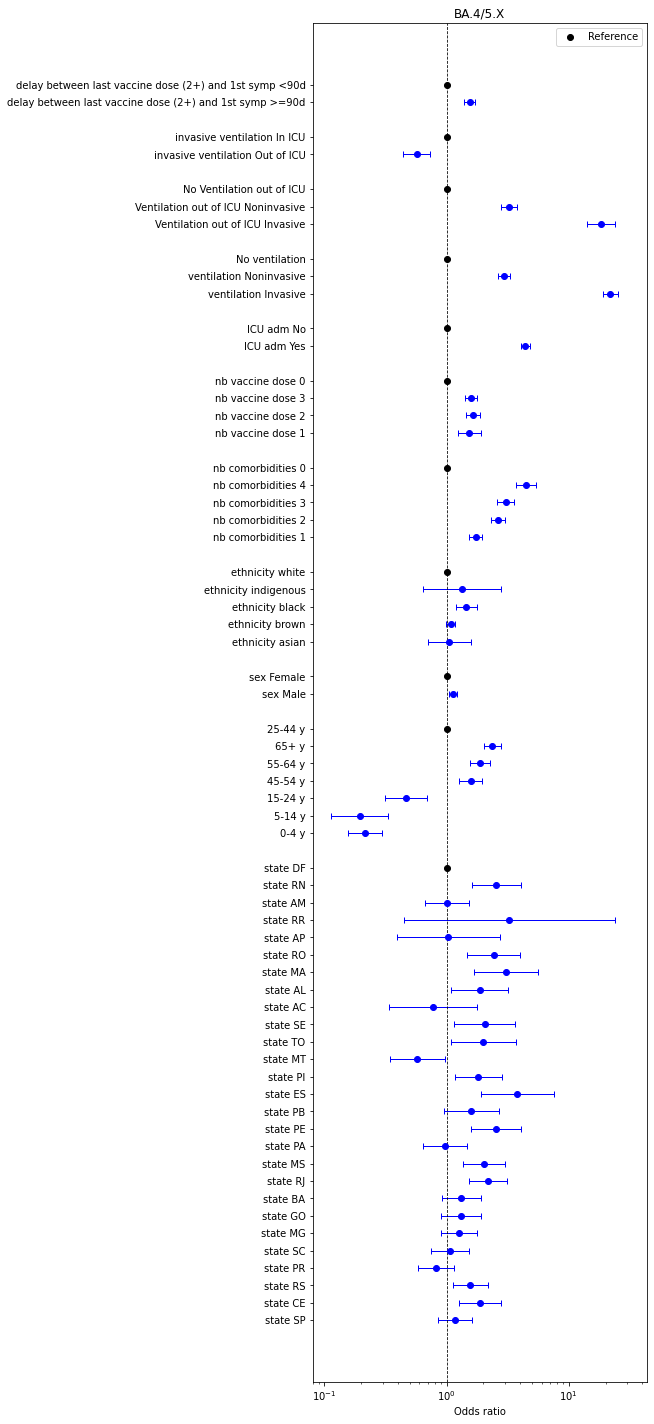

In [4]:
for variant in variants_name:
    plt.figure(figsize=(6,25))
    plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    list_yticks_y = []
    list_yticks_val = []
    list_param = data.columns[data.columns.str.contains(variant)].tolist()
    list_param.insert(0,'param')
    for param in univariate_parameters_withref:
        loc_data = data[data.param.str.startswith(param)][list_param].copy()
        cond_significative = loc_data['p_values_'+variant] <= 0.05
        if param == univariate_parameters_withref[0]:
            list_yticks_y.extend(loc_data['odds_ratio_'+variant].index.values.tolist())
        else:
            list_yticks_y.extend([x+(univariate_parameters_withref.index(param)*2) for x in loc_data['odds_ratio_'+variant].index.values.tolist()])
        yticks_to_add = loc_data.param.values.tolist()
        for element in replace_label:
            yticks_to_add = [sub.replace(element[0],element[1]) for sub in yticks_to_add]
        list_yticks_val.extend(yticks_to_add)
        list_yticks_y.append(max(list_yticks_y)+1)
        yticks_to_add = references[univariate_parameters_withref.index(param)]
        for element in replace_label:
            yticks_to_add = yticks_to_add.replace(element[0],element[1])
        list_yticks_val.append(yticks_to_add)
        if param == univariate_parameters_withref[0]:
            y_val = np.array(loc_data['odds_ratio_'+variant].index.values.tolist())
        else:
            y_val = np.array([x+(univariate_parameters_withref.index(param)*2) for x in loc_data['odds_ratio_'+variant].index.values.tolist()])
        ci = [loc_data['odds_ratio_'+variant]-loc_data['CI_low_'+variant].values,loc_data['CI_high_'+variant].values-loc_data['odds_ratio_'+variant]]
        plt.errorbar(x=loc_data['odds_ratio_'+variant], y=y_val, xerr=ci,
            color='blue',  capsize=3, linestyle='None', linewidth=1)
        if param == univariate_parameters_withref[0]:
            plt.semilogx(loc_data[~cond_significative]['odds_ratio_'+variant],y_val[~cond_significative],'bo')
            plt.semilogx(loc_data[cond_significative]['odds_ratio_'+variant],y_val[cond_significative],'bo')
            plt.semilogx([1],[max(list_yticks_y)],'ko',label='Reference')
            plt.legend()
        else:
            plt.semilogx(loc_data[~cond_significative]['odds_ratio_'+variant],y_val[~cond_significative],'bo')
            plt.semilogx(loc_data[cond_significative]['odds_ratio_'+variant],y_val[cond_significative],'bo')
            plt.semilogx([1],[max(list_yticks_y)],'ko')
    plt.axis([0.08,44,-3.55,74.55])
    plt.yticks(list_yticks_y,list_yticks_val)
    plt.xlabel('Odds ratio')
    plt.title(variant)
    plt.show()    

#### comorbidities: comorbidities independent from each other

In [5]:
univariate_comorbidities = ['cardiovascular_disease','hematologic_disease','down_syndrom','liver_disease','asthma',
                            'diabetes','neurological_disease','chronic_lung_disease','weaken_immune_system',
                            'renal_disease','obesity','puerperal','other_comorbidities']
references = ['No comorbidity']

In [6]:
data = pd.read_csv('comorbidities_by_variant_reg.csv')

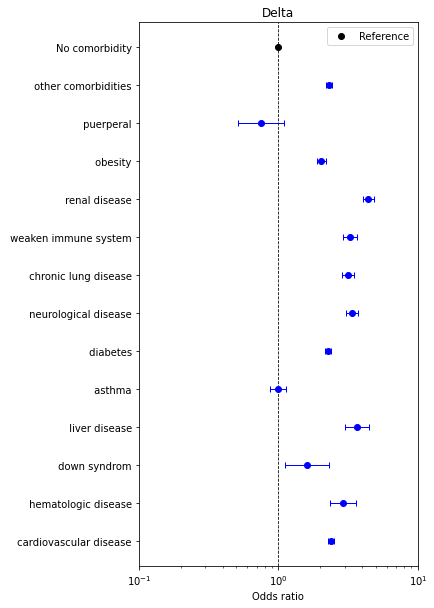

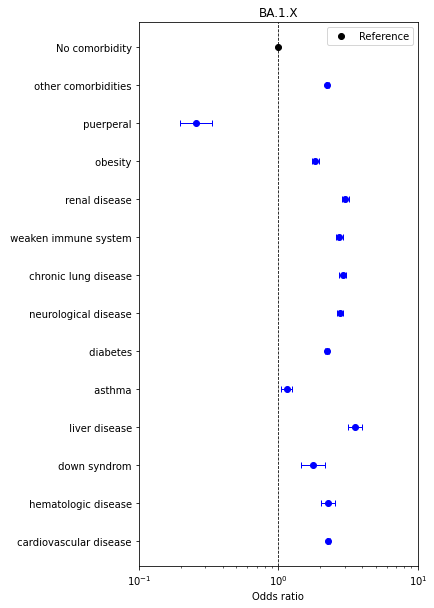

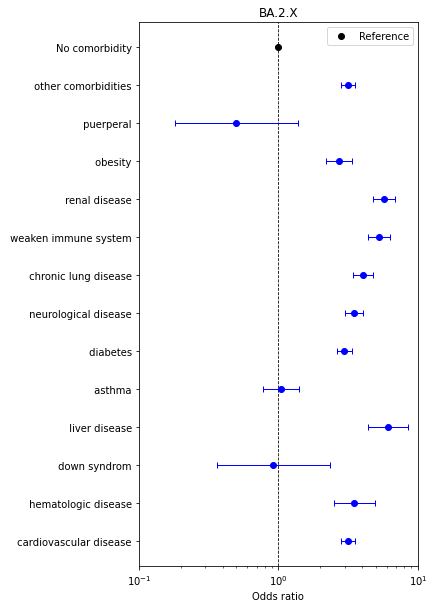

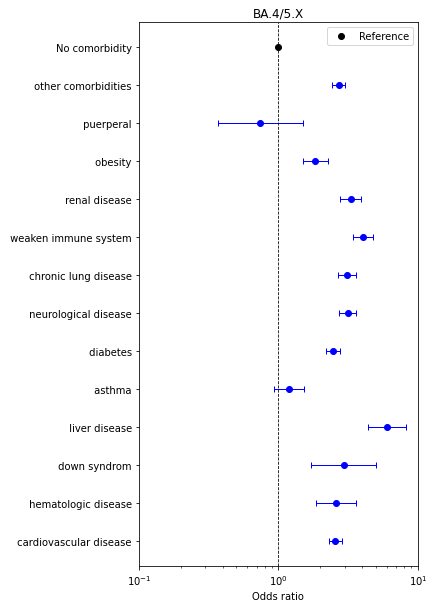

In [7]:
for variant in variants_name:
    plt.figure(figsize=(5,10))
    plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    list_yticks_y = []
    list_yticks_val = []
    list_param = data.columns[data.columns.str.contains(variant)].tolist()
    list_param.insert(0,'param')
    loc_data = data[list_param].copy()
    cond_significative = loc_data['p_values_'+variant] <= 0.05
    list_yticks_y.extend(loc_data['odds_ratio_'+variant].index.values.tolist())
    yticks_to_add = loc_data.param.values.tolist()
    for element in replace_label:
        yticks_to_add = [sub.replace(element[0],element[1]) for sub in yticks_to_add]
    list_yticks_val.extend(yticks_to_add)
    list_yticks_y.append(max(list_yticks_y)+1)
    list_yticks_val.append(references[0])
    y_val = np.array(loc_data['odds_ratio_'+variant].index.values.tolist())
    ci = [loc_data['odds_ratio_'+variant]-loc_data['CI_low_'+variant].values,loc_data['CI_high_'+variant].values-loc_data['odds_ratio_'+variant]]
    plt.errorbar(x=loc_data['odds_ratio_'+variant], y=y_val, xerr=ci,color='blue',  capsize=3, linestyle='None', 
                 linewidth=1)
    plt.semilogx(loc_data[~cond_significative]['odds_ratio_'+variant],y_val[~cond_significative],'bo')
    plt.semilogx(loc_data[cond_significative]['odds_ratio_'+variant],y_val[cond_significative],'bo')
    plt.semilogx([1],[max(list_yticks_y)],'ko',label='Reference')
    plt.legend()
    plt.axis([0.1,10,-0.65,13.65])
    plt.yticks(list_yticks_y,list_yticks_val)
    plt.xlabel('Odds ratio')
    plt.title(variant)
    plt.show()    

#### comorbidities: all comorbidities considered together

In [8]:
data = pd.read_csv('comorbidities_dependent_by_variant_reg.csv')

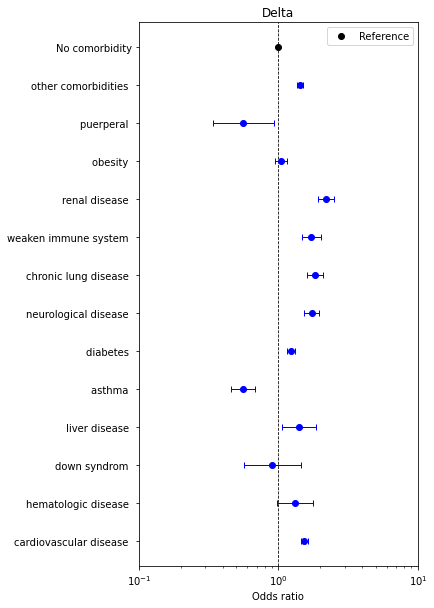

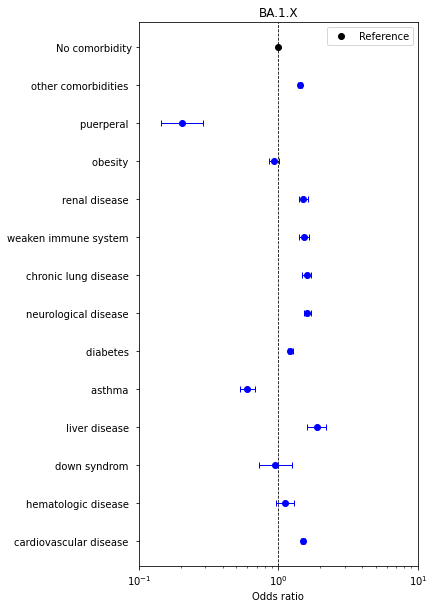

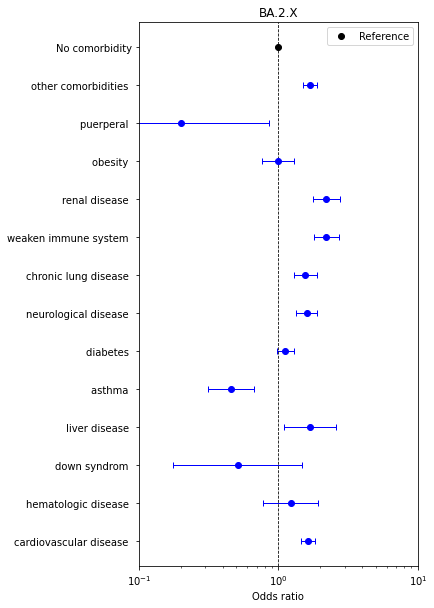

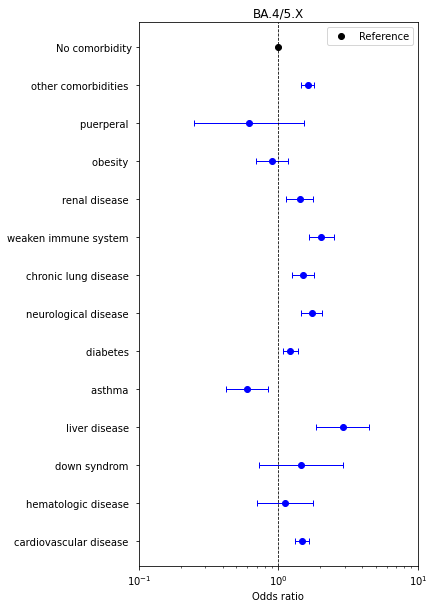

In [10]:
for variant in variants_name:
    plt.figure(figsize=(5,10))
    plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    list_yticks_y = []
    list_yticks_val = []
    list_param = data.columns[data.columns.str.contains(variant)].tolist()
    list_param.insert(0,'param')
    loc_data = data[list_param].copy()
    cond_significative = loc_data['p_values_'+variant] <= 0.05
    list_yticks_y.extend(loc_data['odds_ratio_'+variant].index.values.tolist())
    #
    yticks_to_add = loc_data.param.values.tolist()
    for element in replace_label:
        yticks_to_add = [sub.replace(element[0],element[1]) for sub in yticks_to_add]
    list_yticks_val.extend(yticks_to_add)
    #
#    list_yticks_val.extend(loc_data.param.values.tolist())
    list_yticks_y.append(max(list_yticks_y)+1)
    list_yticks_val.append(references[0])
    y_val = np.array(loc_data['odds_ratio_'+variant].index.values.tolist())
    ci = [loc_data['odds_ratio_'+variant]-loc_data['CI_low_'+variant].values,loc_data['CI_high_'+variant].values-loc_data['odds_ratio_'+variant]]
    plt.errorbar(x=loc_data['odds_ratio_'+variant], y=y_val, xerr=ci,color='blue',  capsize=3, linestyle='None', 
                 linewidth=1)
    plt.semilogx(loc_data[~cond_significative]['odds_ratio_'+variant],y_val[~cond_significative],'bo')
    plt.semilogx(loc_data[cond_significative]['odds_ratio_'+variant],y_val[cond_significative],'bo')
    plt.semilogx([1],[max(list_yticks_y)],'ko',label='Reference')
    plt.legend()
    plt.axis([0.1,10,-0.65,13.65])
    plt.yticks(list_yticks_y,list_yticks_val)
    plt.xlabel('Odds ratio')
    plt.title(variant)
    plt.show()    

### Univariate logistic regression per variant: secondary outcomes

- ICU admission
- Invasive ventilation

In [12]:
outcomes = ['ventilation_invasive','icu_adm']
outcome_delete_from_parameters = [['invasive_ventilation','ventilation ','ventilation_outoficu'],['icuadm','ventilation_outoficu',
                                                                                                 'invasive_ventilation']]
univariate_parameters_withref = ['state','age_group','sex','ethnicity','nb_comorbidities','nb_vaccine_dose','icuadm',
                                 'ventilation ','ventilation_outoficu','invasive_ventilation','delay_vaccine']
univariate_parameters = ['length_stay','length_delay']
references = [['state DF','age_group 3','sex Female','ethnicity white','nb_comorbidities 0','nb_vaccine_dose 0','icuadm No','delay_vaccine <90']
              ,['state DF','age_group 3','sex Female','ethnicity white','nb_comorbidities 0','nb_vaccine_dose 0','No ventilation','delay_vaccine <90']]

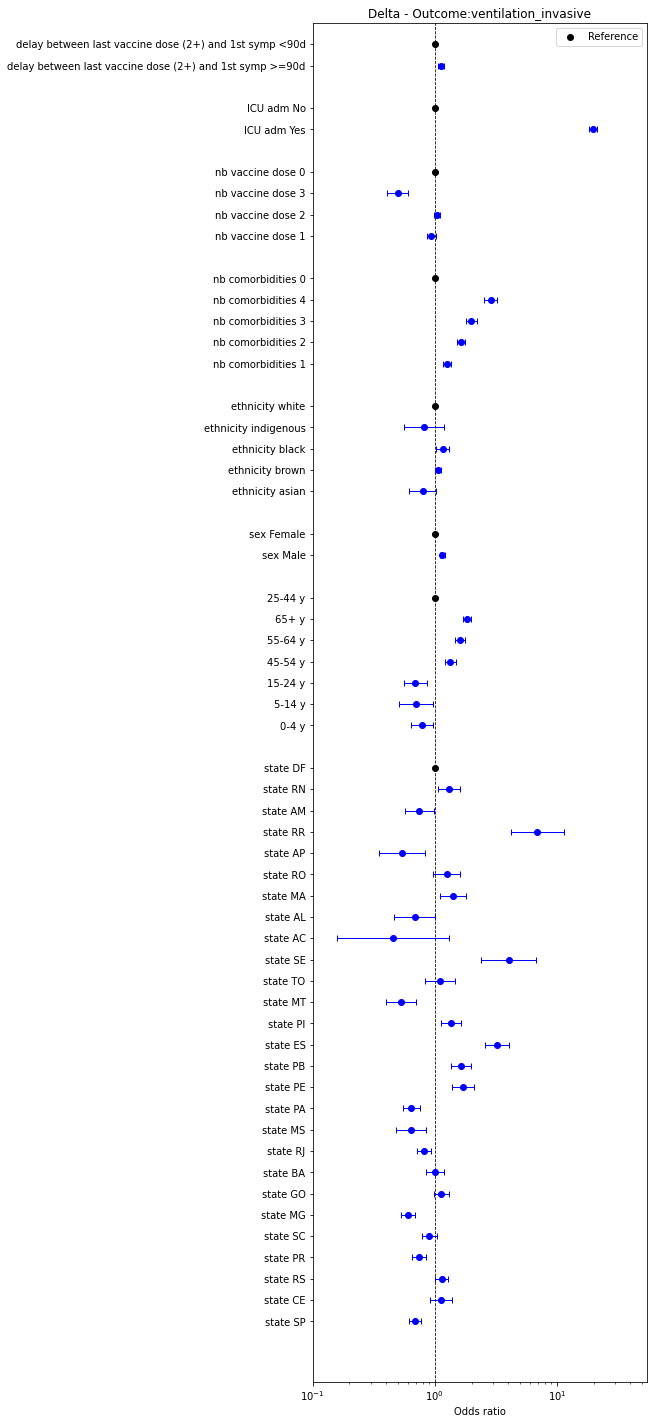

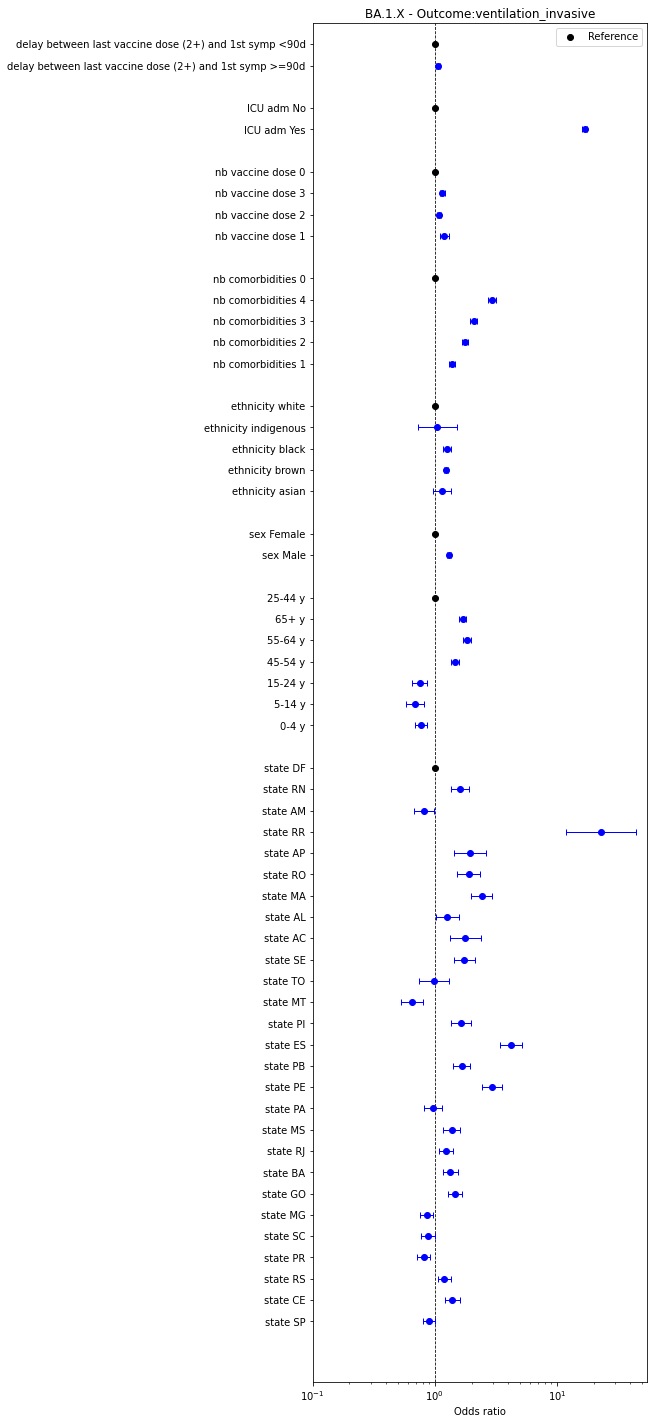

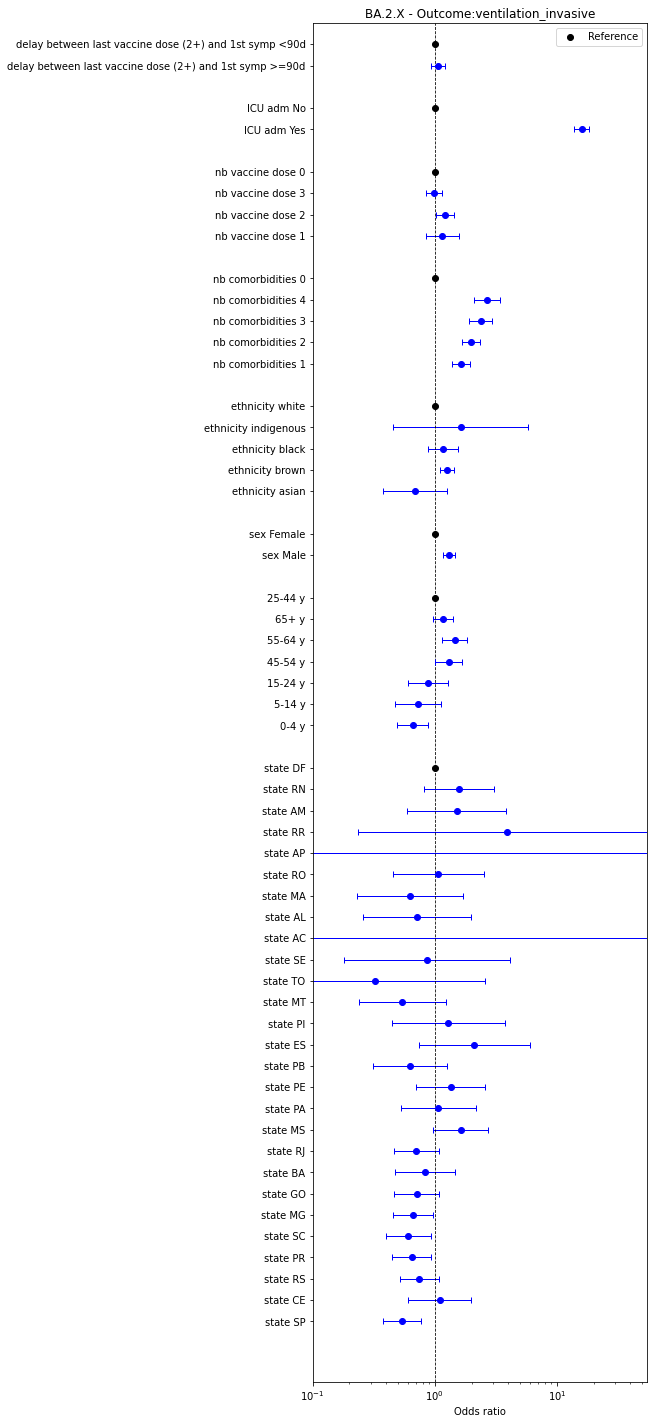

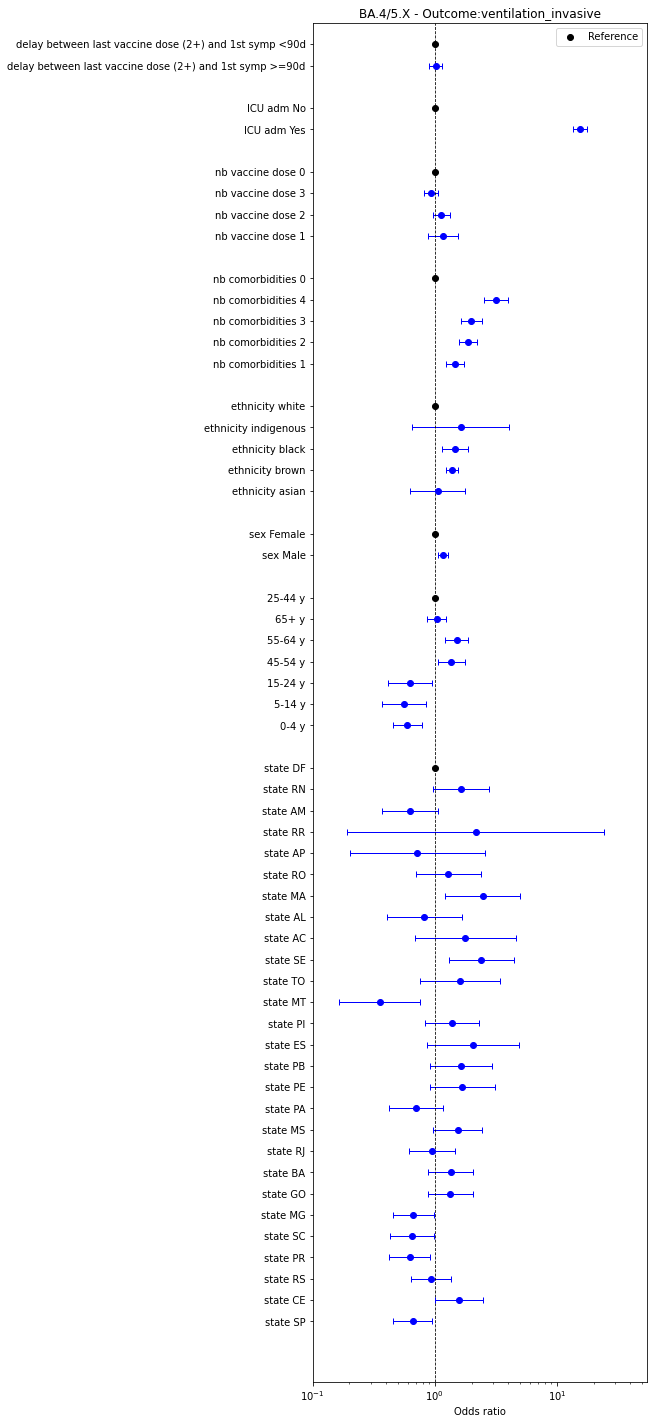

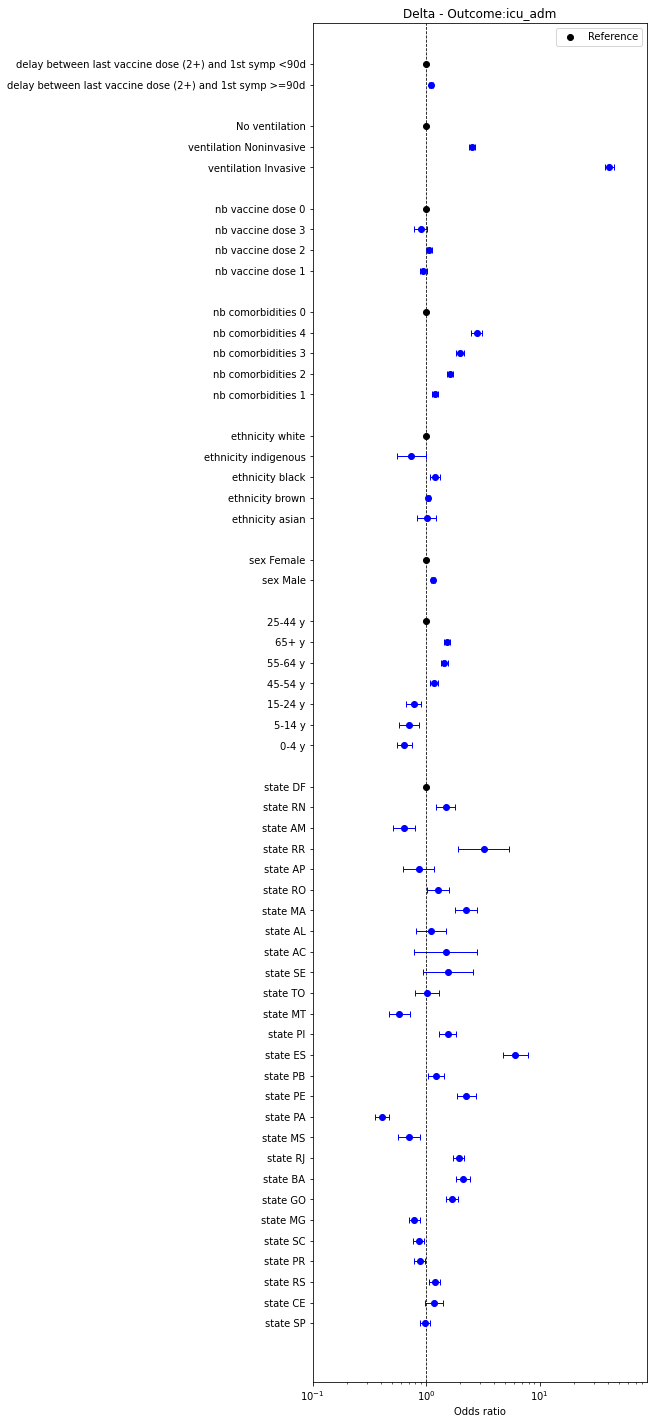

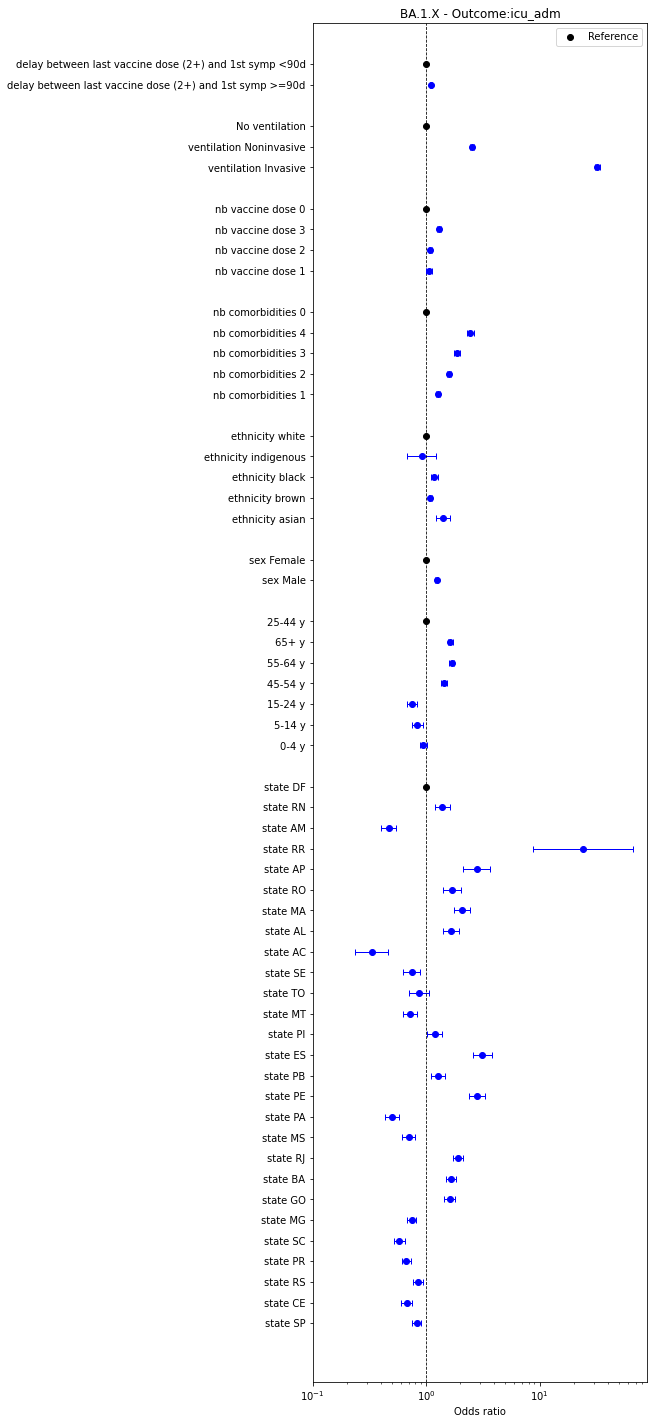

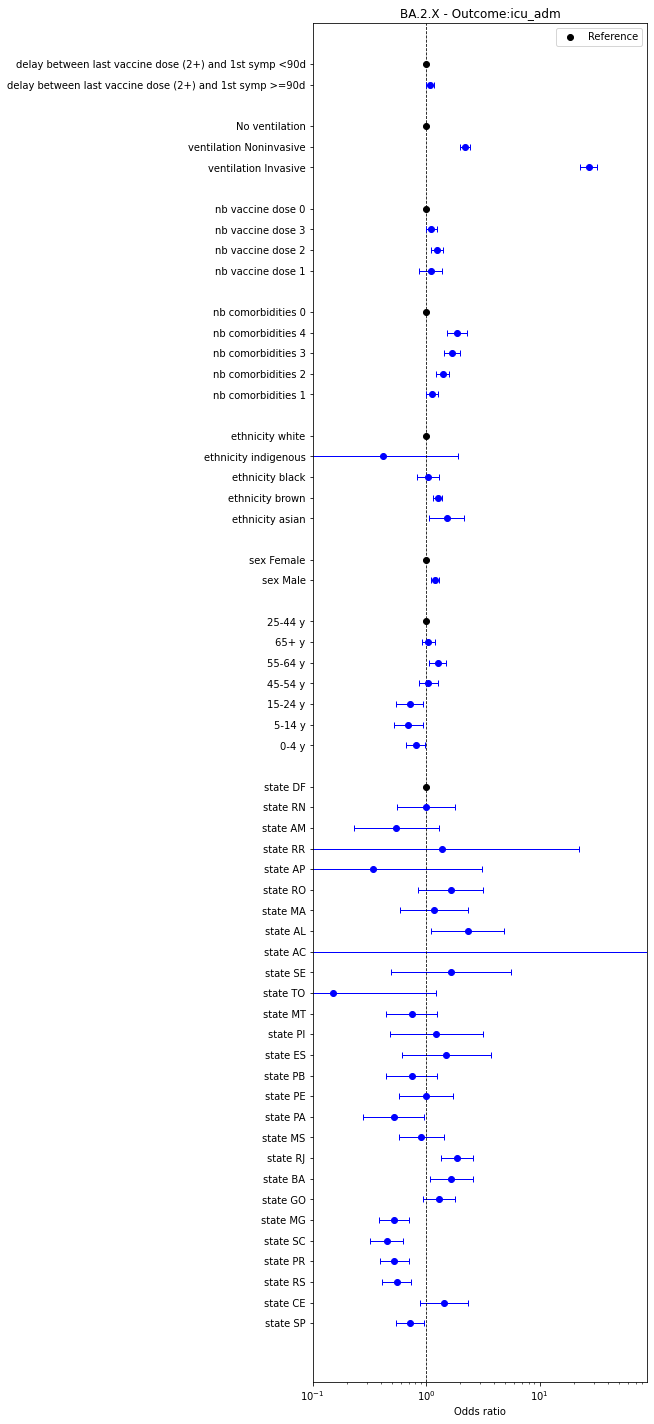

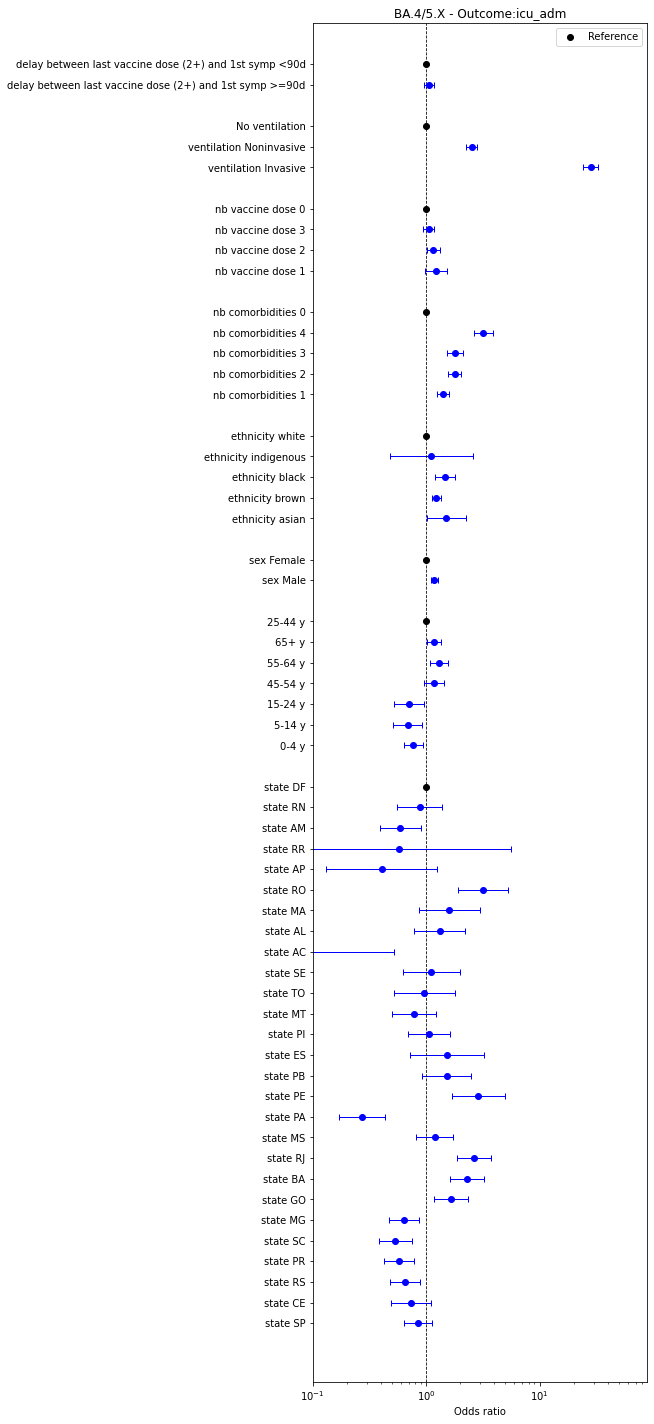

In [14]:
for outcome in outcomes:
    data = pd.read_csv(outcome+'_categorical_by_variant_reg.csv')
    local_parameters = univariate_parameters_withref.copy()
    if type(outcome_delete_from_parameters[outcomes.index(outcome)]) == list:
        for element in outcome_delete_from_parameters[outcomes.index(outcome)]:
            local_parameters.remove(element)
    else:
        local_parameters.remove(outcome_delete_from_parameters[outcomes.index(outcome)])
    loc_ref = references[outcomes.index(outcome)]
    for variant in variants_name:
        plt.figure(figsize=(6,25))
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        list_yticks_y = []
        list_yticks_val = []
        list_param = data.columns[data.columns.str.contains(variant)].tolist()
        list_param.insert(0,'param') 
        for param in local_parameters:
            loc_data = data[data.param.str.startswith(param)][list_param].copy()
            cond_significative = loc_data['p_values_'+variant] <= 0.05
            if param == local_parameters[0]:
                list_yticks_y.extend(loc_data['odds_ratio_'+variant].index.values.tolist())
                list_yticks_val.extend(loc_data.param.values.tolist())
            else:
                list_yticks_y.extend([x+(local_parameters.index(param)*2) for x in loc_data['odds_ratio_'+variant].index.values.tolist()])
                list_yticks_val.extend(loc_data.param.values.tolist())
            list_yticks_y.append(max(list_yticks_y)+1)
            list_yticks_val.append(loc_ref[local_parameters.index(param)])
            #
            yticks_to_add = list_yticks_val.copy()
            for element in replace_label:
                yticks_to_add = [sub.replace(element[0],element[1]) for sub in yticks_to_add]
            list_yticks_val = yticks_to_add.copy()
            #
            if param == local_parameters[0]:
                y_val = np.array(loc_data['odds_ratio_'+variant].index.values.tolist())
            else:
                y_val = np.array([x+(local_parameters.index(param)*2) for x in loc_data['odds_ratio_'+variant].index.values.tolist()])
            ci = [loc_data['odds_ratio_'+variant]-loc_data['CI_low_'+variant].values,loc_data['CI_high_'+variant].values-loc_data['odds_ratio_'+variant]]
            plt.errorbar(x=loc_data['odds_ratio_'+variant], y=y_val, xerr=ci,color='blue',  capsize=3, linestyle='None', 
                         linewidth=1)
            if param == local_parameters[0]:
                plt.semilogx(loc_data[~cond_significative]['odds_ratio_'+variant],y_val[~cond_significative],'bo')
                plt.semilogx(loc_data[cond_significative]['odds_ratio_'+variant],y_val[cond_significative],'bo')
                plt.semilogx([1],[max(list_yticks_y)],'ko',label='Reference')
                plt.legend()
            else:
                plt.semilogx(loc_data[~cond_significative]['odds_ratio_'+variant],y_val[~cond_significative],'bo')
                plt.semilogx(loc_data[cond_significative]['odds_ratio_'+variant],y_val[cond_significative],'bo')
                plt.semilogx([1],[max(list_yticks_y)],'ko')
        if outcome == 'ventilation_invasive':
            plt.axis([0.1,55,-2.85,61])
        else:
            plt.axis([0.1,89,-2.85,63])
        plt.yticks(list_yticks_y,list_yticks_val)
        plt.xlabel('Odds ratio')
        plt.title(variant+' - Outcome:'+outcome)
        plt.show()    

#### comorbidities: comorbidities independent from each other

In [15]:
univariate_comorbidities = ['cardiovascular_disease','hematologic_disease','down_syndrom','liver_disease','asthma',
                            'diabetes','neurological_disease','chronic_lung_disease','weaken_immune_system',
                            'renal_disease','obesity','puerperal','other_comorbidities']
references = ['No comorbidity']

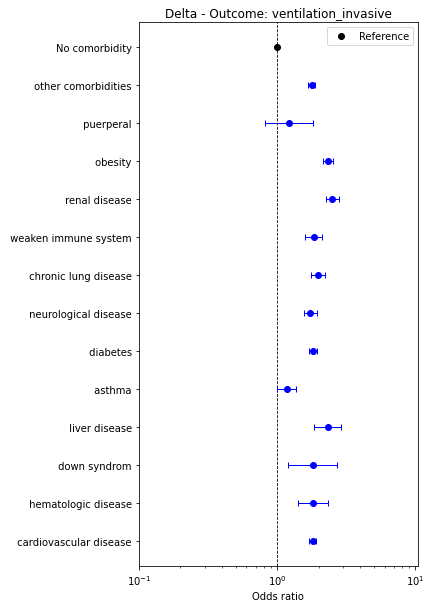

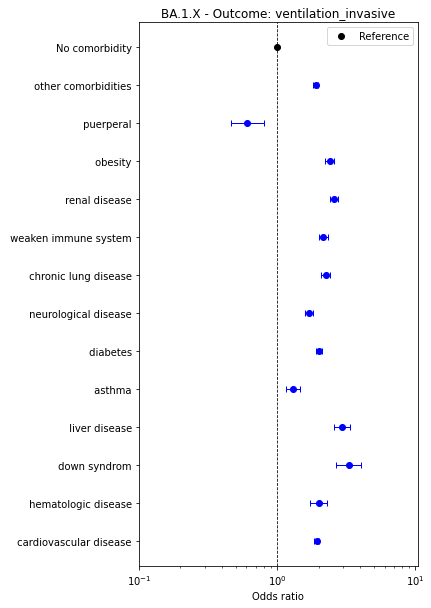

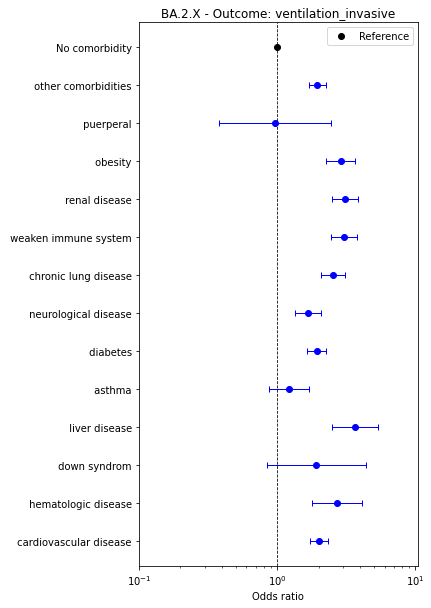

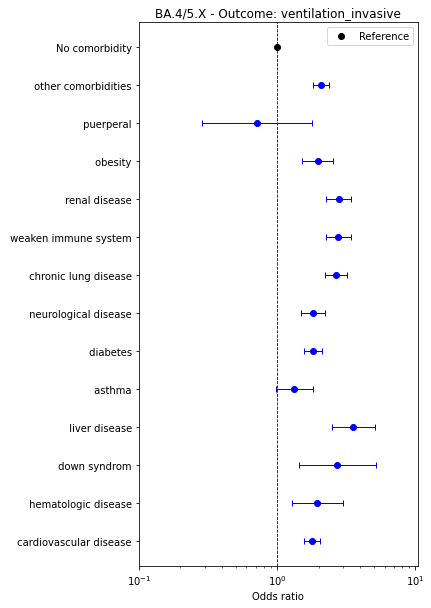

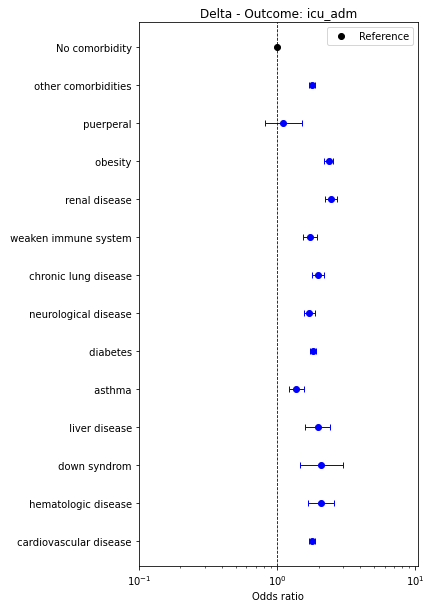

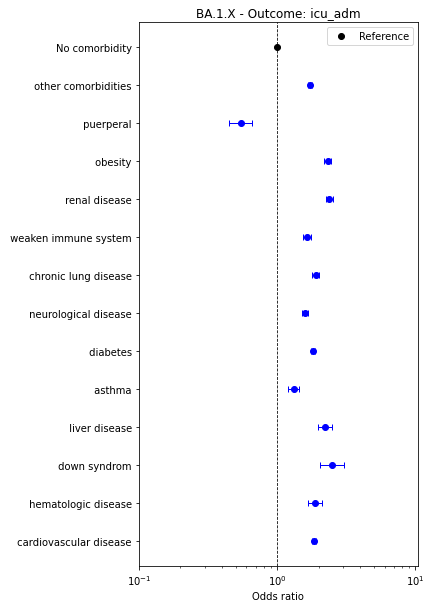

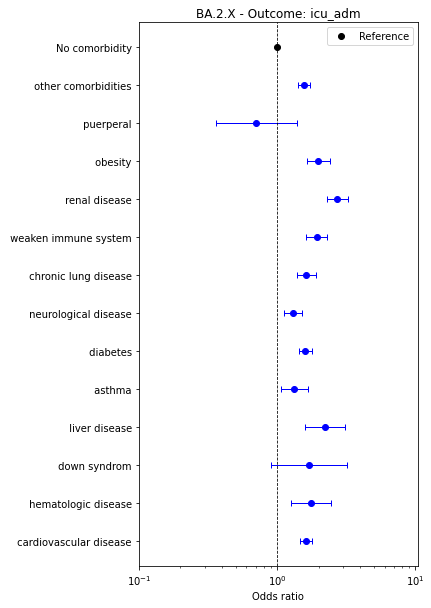

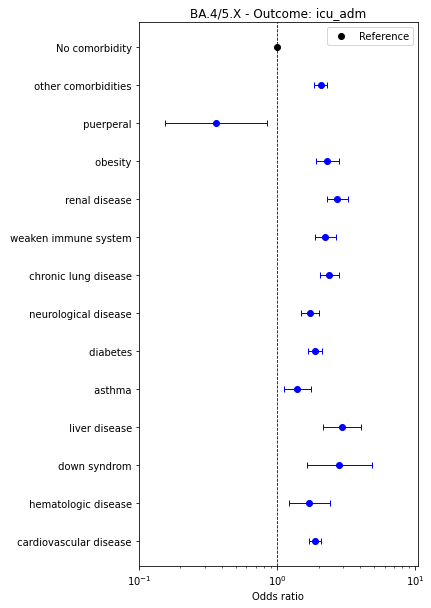

In [17]:
for outcome in outcomes:
    data = pd.read_csv(outcome+'_comorbidities_by_variant_reg.csv')
    for variant in variants_name:
        plt.figure(figsize=(5,10))
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        list_yticks_y = []
        list_yticks_val = []
        list_param = data.columns[data.columns.str.contains(variant)].tolist()
        list_param.insert(0,'param')
        loc_data = data[list_param].copy()
        cond_significative = loc_data['p_values_'+variant] <= 0.05
        list_yticks_y.extend(loc_data['odds_ratio_'+variant].index.values.tolist())
        list_yticks_val.extend(loc_data.param.values.tolist())
        #
        yticks_to_add = list_yticks_val.copy()
        for element in replace_label:
            yticks_to_add = [sub.replace(element[0],element[1]) for sub in yticks_to_add]
        list_yticks_val = yticks_to_add.copy()
        #
        list_yticks_y.append(max(list_yticks_y)+1)
        list_yticks_val.append(references[0])
        y_val = np.array(loc_data['odds_ratio_'+variant].index.values.tolist())
        ci = [loc_data['odds_ratio_'+variant]-loc_data['CI_low_'+variant].values,loc_data['CI_high_'+variant].values-loc_data['odds_ratio_'+variant]]
        plt.errorbar(x=loc_data['odds_ratio_'+variant], y=y_val, xerr=ci,color='blue',  capsize=3, linestyle='None', 
                     linewidth=1)
        plt.semilogx(loc_data[~cond_significative]['odds_ratio_'+variant],y_val[~cond_significative],'bo')
        plt.semilogx(loc_data[cond_significative]['odds_ratio_'+variant],y_val[cond_significative],'bo')
        plt.semilogx([1],[max(list_yticks_y)],'ko',label='Reference')
        plt.legend()
        plt.axis([0.1,10.4,-0.65,13.65])
        plt.yticks(list_yticks_y,list_yticks_val)
        plt.xlabel('Odds ratio')
        plt.title(variant+' - Outcome: '+outcome)
        plt.show()    

#### comorbidities: all comorbidities considered together

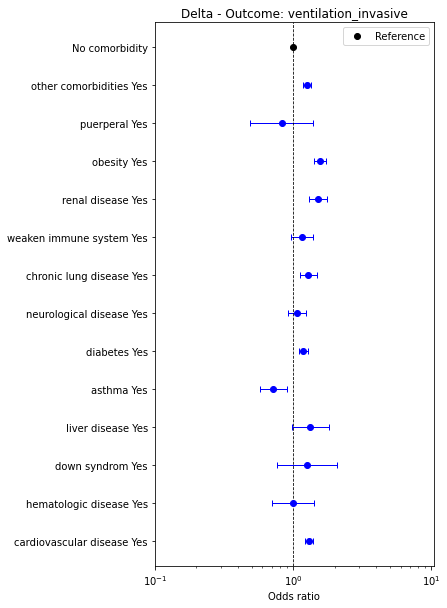

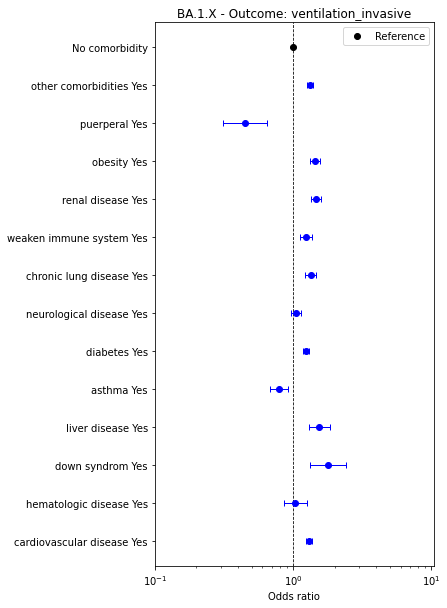

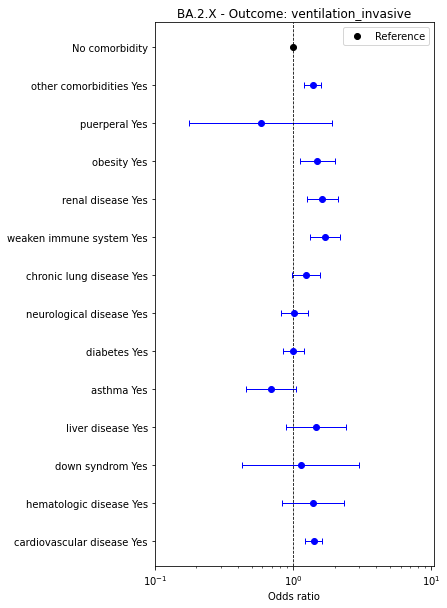

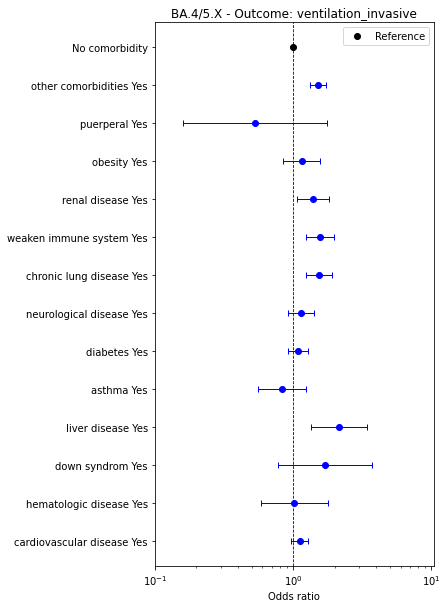

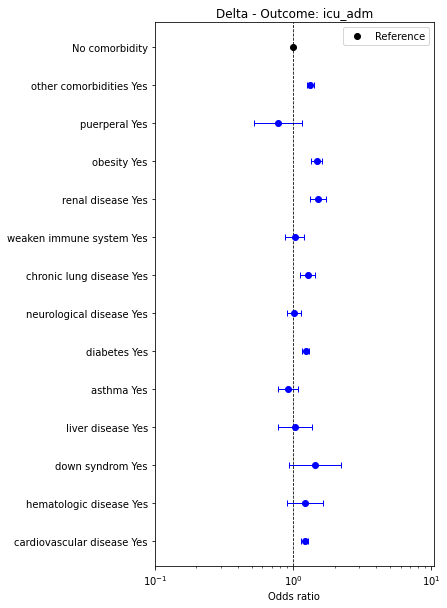

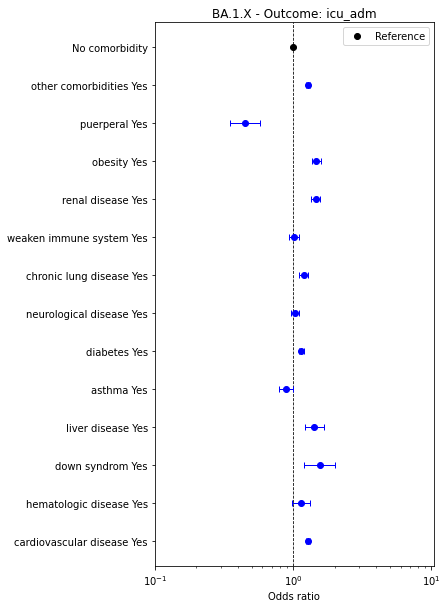

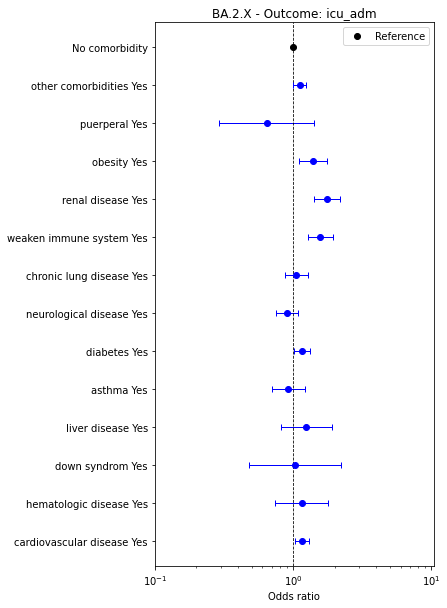

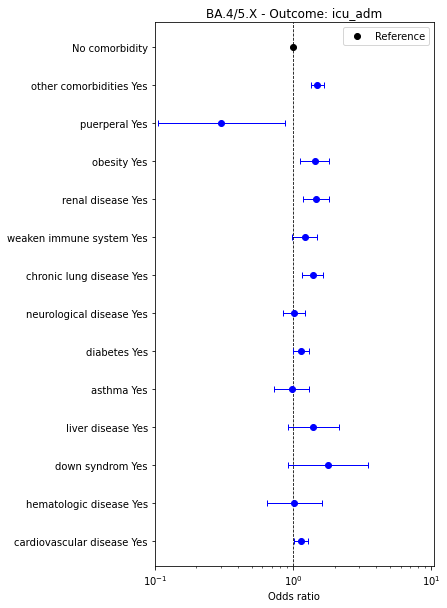

In [18]:
for outcome in outcomes:
    data = pd.read_csv(outcome+'_comorbidities_dependent_by_variant_reg.csv')
    for variant in variants_name:
        plt.figure(figsize=(5,10))
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        list_yticks_y = []
        list_yticks_val = []
        list_param = data.columns[data.columns.str.contains(variant)].tolist()
        list_param.insert(0,'param')
        loc_data = data[list_param].copy()
        cond_significative = loc_data['p_values_'+variant] <= 0.05
        list_yticks_y.extend(loc_data['odds_ratio_'+variant].index.values.tolist())
        list_yticks_val.extend(loc_data.param.values.tolist())
        list_yticks_y.append(max(list_yticks_y)+1)
        list_yticks_val.append(references[0])
        #
        yticks_to_add = list_yticks_val.copy()
        for element in replace_label:
            yticks_to_add = [sub.replace(element[0],element[1]) for sub in yticks_to_add]
        list_yticks_val = yticks_to_add.copy()
        #
        y_val = np.array(loc_data['odds_ratio_'+variant].index.values.tolist())
        ci = [loc_data['odds_ratio_'+variant]-loc_data['CI_low_'+variant].values,loc_data['CI_high_'+variant].values-loc_data['odds_ratio_'+variant]]
        plt.errorbar(x=loc_data['odds_ratio_'+variant], y=y_val, xerr=ci,color='blue',  capsize=3, linestyle='None', 
                     linewidth=1)
        plt.semilogx(loc_data[~cond_significative]['odds_ratio_'+variant],y_val[~cond_significative],'bo')
        plt.semilogx(loc_data[cond_significative]['odds_ratio_'+variant],y_val[cond_significative],'bo')
        plt.semilogx([1],[max(list_yticks_y)],'ko',label='Reference')
        plt.legend()
        plt.axis([0.1,10.4,-0.65,13.65])
        plt.yticks(list_yticks_y,list_yticks_val)
        plt.xlabel('Odds ratio')
        plt.title(variant+' - Outcome: '+outcome)
        plt.show()    

### Univariate logistic regression with variant combination: primary outcome

In [19]:
data = pd.read_csv('variant_combination_reg.csv')
data

,param,odds_ratio,CI_low,CI_high,p_values
0,BA.1.X - Ref: Delta,1.083714,1.059446,1.108538,3.469490e-12
1,BA.2.X - Ref: BA.1.X,0.616089,0.590547,0.642735,2.479551e-111
2,BA.4/5.X - Ref: BA.2.X,1.234705,1.167854,1.305382,1.140324e-13


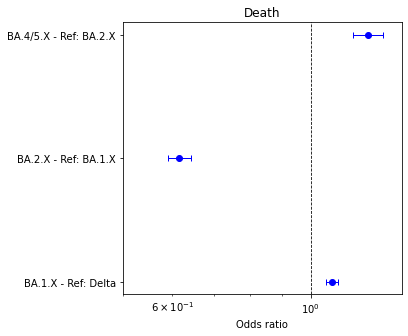

In [21]:
loc_data = pd.read_csv('variant_combination_reg.csv')
cond_significative = loc_data['p_values'] <= 0.05
plt.figure(figsize=(5,5))
list_yticks_y = []
list_yticks_val = []
list_yticks_y.extend(loc_data['odds_ratio'].index.values.tolist())
list_yticks_val.extend(loc_data.param.values.tolist())
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
y_val = np.array(loc_data['odds_ratio'].index.values.tolist())
ci = [loc_data['odds_ratio']-loc_data['CI_low'].values,loc_data['CI_high'].values-loc_data['odds_ratio']]
plt.errorbar(x=loc_data['odds_ratio'], y=y_val, xerr=ci,color='blue',  capsize=3, linestyle='None', 
                     linewidth=1)
list_param = data.columns[data.columns.str.contains(variant)].tolist()
list_param.insert(0,'param')
plt.semilogx(loc_data[~cond_significative]['odds_ratio'],y_val[~cond_significative],'bo')
plt.semilogx(loc_data[cond_significative]['odds_ratio'],y_val[cond_significative],'bo')
plt.axis([0.5,1.4,-0.1,2.1])
plt.yticks(list_yticks_y,list_yticks_val)
plt.xlabel('Odds ratio')
plt.title('Death')
plt.show()    

In [22]:
outcomes = ['ventilation_invasive','icu_adm']
variant_combination = [['Delta','BA.1.X'],['BA.1.X','BA.2.X'],['BA.2.X','BA.4/5.X']]

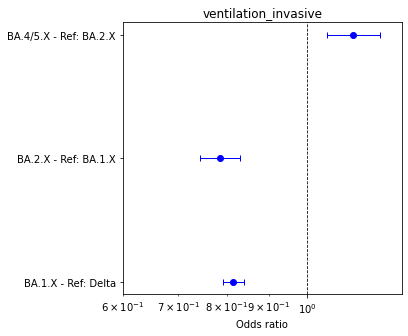

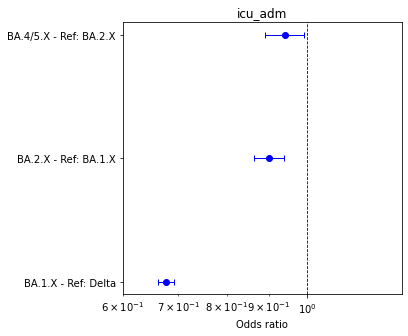

In [23]:
for outcome in outcomes:
    loc_data = pd.read_csv(outcome+'_variant_combination_reg.csv')
    cond_significative = loc_data['p_values'] <= 0.05
    plt.figure(figsize=(5,5))
    list_yticks_y = []
    list_yticks_val = []
    list_yticks_y.extend(loc_data['odds_ratio'].index.values.tolist())
    list_yticks_val.extend(loc_data.param.values.tolist())
    plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    y_val = np.array(loc_data['odds_ratio'].index.values.tolist())
    ci = [loc_data['odds_ratio']-loc_data['CI_low'].values,loc_data['CI_high'].values-loc_data['odds_ratio']]
    plt.errorbar(x=loc_data['odds_ratio'], y=y_val, xerr=ci,color='blue',  capsize=3, linestyle='None', 
                         linewidth=1)
    list_param = data.columns[data.columns.str.contains(variant)].tolist()
    list_param.insert(0,'param')
    plt.semilogx(loc_data[~cond_significative]['odds_ratio'],y_val[~cond_significative],'bo')
    plt.semilogx(loc_data[cond_significative]['odds_ratio'],y_val[cond_significative],'bo')
    plt.axis([0.6,1.3,-0.1,2.1])
    plt.yticks(list_yticks_y,list_yticks_val)
    plt.xlabel('Odds ratio')
    plt.title(outcome)
    plt.show()    